In [1]:
import pandas as pd

def load_TRTH_trade(filename,
             tz_exchange="America/New_York",
             only_non_special_trades=True,
             only_regular_trading_hours=True,
             open_time="09:30:00",
             close_time="16:00:00",
             merge_sub_trades=True):
    
    DF = pd.read_csv(filename)

    if only_non_special_trades:
        DF = DF[DF["trade-stringflag"]=="uncategorized"]

    DF.drop(columns=["trade-rawflag","trade-stringflag"],axis=1,inplace=True)
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
    
    if merge_sub_trades:
           DF=DF.groupby(DF.index).agg(trade_price=pd.NamedAgg(column='trade-price', aggfunc='mean'),
                                       trade_volume=pd.NamedAgg(column='trade-volume', aggfunc='sum'))
    
    return DF

def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             open_time="09:30:00",
             close_time="16:00:00",
             only_regular_trading_hours=True):
    
    DF = pd.read_csv(filename)

    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF

In [2]:
trades = load_TRTH_trade("data/raw/TRTH/equities/US/trade/SPY.P//2017-01-03-SPY.P-trade.csv.gz")
bbos   = load_TRTH_bbo("data/raw/TRTH/equities/US/bbo/SPY.P/2017-01-03-SPY.P-bbo.csv.gz")



(24333, 2)
(961046, 4)


In [4]:
trades = load_TRTH_trade("data/raw/TRTH/equities/US/trade/SPY.P//2017-01-03-SPY.P-trade.csv.gz")
trades

,trade_price,trade_volume
xltime,,
2017-01-03 09:30:00.772963200-05:00,225.075,800.0
2017-01-03 09:30:00.782985600-05:00,225.065,200.0
2017-01-03 09:30:00.822038400-05:00,225.080,1200.0
2017-01-03 09:30:00.850982400-05:00,225.070,5054.0
2017-01-03 09:30:00.862991999-05:00,225.060,1710.0
...,...,...
2017-01-03 15:59:59.250998400-05:00,225.160,200.0
2017-01-03 15:59:59.613964800-05:00,225.170,200.0
2017-01-03 15:59:59.700019200-05:00,225.170,1331.0


In [5]:
bbos   = load_TRTH_bbo("data/raw/TRTH/equities/US/bbo/SPY.P/2017-01-03-SPY.P-bbo.csv.gz")
bbos

,bid-price,bid-volume,ask-price,ask-volume
xltime,,,,
2017-01-03 09:30:00.073987200-05:00,225.03,105,225.04,4
2017-01-03 09:30:00.681984-05:00,225.03,105,225.08,89
2017-01-03 09:30:00.772963200-05:00,225.03,115,225.08,89
2017-01-03 09:30:00.772963200-05:00,225.05,1,225.08,89
2017-01-03 09:30:00.772963200-05:00,225.06,44,225.08,89
...,...,...,...,...
2017-01-03 15:59:59.991014400-05:00,225.17,71,225.18,45
2017-01-03 15:59:59.991014400-05:00,225.17,85,225.18,45
2017-01-03 15:59:59.994038400-05:00,225.17,85,225.18,44


In [28]:
events_all = trades.join(bbos,how="outer")
print(trades.shape)
print(bbos.shape)
print(events_all.shape)

(24333, 2)
(961046, 4)
(962374, 6)


In [21]:
events_common = trades.join(bbos)
print(trades.shape)
print(bbos.shape)
print(events_common.shape)

(24333, 2)
(961046, 4)
(208060, 6)


In [23]:
events_common_first=events_common.groupby(events_common.index).first()
print(events_common_first.shape)

(24333, 6)


In [30]:
events_all.ffill(inplace=True)
events_all

,trade_price,trade_volume,bid-price,bid-volume,ask-price,ask-volume
xltime,,,,,,
2017-01-03 09:30:00.073987200-05:00,NaN,NaN,225.03,105.0,225.04,4.0
2017-01-03 09:30:00.681984-05:00,NaN,NaN,225.03,105.0,225.08,89.0
2017-01-03 09:30:00.772963200-05:00,225.075,800.0,225.03,115.0,225.08,89.0
2017-01-03 09:30:00.772963200-05:00,225.075,800.0,225.05,1.0,225.08,89.0
2017-01-03 09:30:00.772963200-05:00,225.075,800.0,225.06,44.0,225.08,89.0
...,...,...,...,...,...,...
2017-01-03 15:59:59.991014400-05:00,225.170,4469.0,225.17,71.0,225.18,45.0
2017-01-03 15:59:59.991014400-05:00,225.170,4469.0,225.17,85.0,225.18,45.0
2017-01-03 15:59:59.994038400-05:00,225.170,400.0,225.17,85.0,225.18,44.0


In [36]:
import sys
sys.getsizeof(events_all)/1024/1024   # in Megabytes

51.39634704589844

In [67]:
import numpy as np
bbos["logmid"]=np.log((bbos["ask-price"]+bbos["bid-price"])/2)

In [81]:
s2=[]
ks=range(1,30,1)
for k in ks:
    resample_freq = str(k)+"s"
    logrets=bbos["logmid"].resample(resample_freq).last().diff()
    logrets=logrets[logrets!=0]
    s2.append(np.nanmean(logrets*logrets))

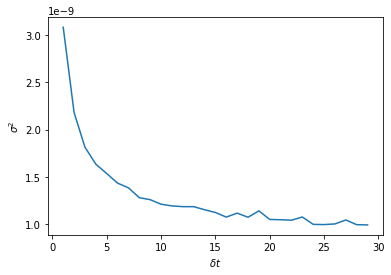

In [86]:
import matplotlib.pyplot as plt
plt.plot(ks,s2/np.array(ks))
plt.xlabel(r"$\delta t$")
plt.ylabel(r"$\sigma^2$")
plt.savefig("signature_plot.pdf")

In [87]:
bbos["spread"]=bbos["ask-price"]-bbos["bid-price"]
bbos["tot-volume"]=bbos["bid-volume"]+bbos["ask-volume"]

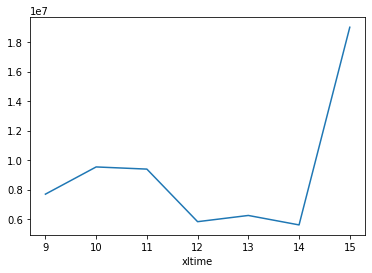

In [91]:
bbos["tot-volume"].groupby(bbos.index.hour).sum().plot()

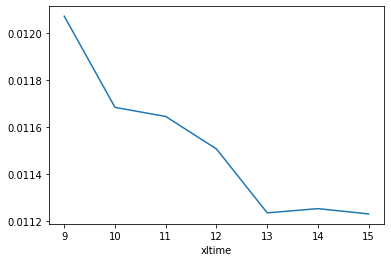

In [92]:
bbos["spread"].groupby(bbos.index.hour).mean().plot()

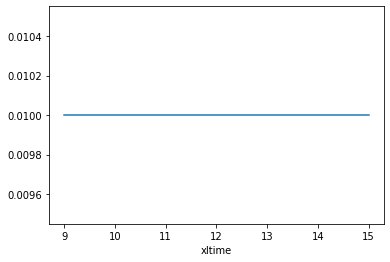

In [117]:
bbos["spread"].groupby(bbos.index.hour).median().plot()   # SPY is a "large-tick" asset: the spread is most of
                                                          # exactly 1 tick. AAPL on the other hand is a small-tick
                                                          # asset

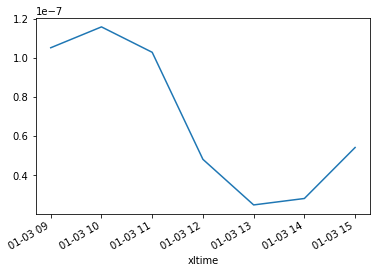

In [116]:
#with a single day of data, one needs to sample price returns at smaller time intervals
# and then average the realized volatility at larger time intervals 
(((bbos["logmid"].resample("1Min").last()).diff())**2).resample("60Min").mean().plot()

In [125]:
import dask
dask.config.set(scheduler='processes')

import glob

@dask.delayed
def loadTRTH(myfile):
    return pd.read_csv(myfile)
    
allfiles=glob.glob("data/raw/TRTH/equities/US/trade/SPY.P/*csv.gz")

allpromises=[loadTRTH(i) for i in allfiles]

In [126]:
alldata=dask.compute(allpromises)